In [5]:
from src.clp_zne.qpu_info.layout_cycles import heron_layout_cycles_12q
from src.clp_zne.hamiltonians import sherrington_kirkpatrick_model
from src.clp_zne.qpu_info.backends import FakeTorino
from src.clp_zne.mitigate import CLP_ZNE_mitigate
from src.clp_zne.utils import compute_evals_ideal
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import TwoLocal
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm
import numpy as np
import pickle
import os

In [3]:
backend = FakeTorino()
n_qubits = 12
observables = [sherrington_kirkpatrick_model(n_qubits, h=1, seed=i) for i in range(100)]

circuits = []
for i in range(20):
    circ = TwoLocal(n_qubits, ['rx', 'rz'], 'cz', entanglement="circular", reps=3)
    rng = np.random.default_rng(i)
    parameters = rng.uniform(-np.pi, np.pi, circ.num_parameters)
    circ.assign_parameters(parameters, inplace=True)
    circuits.append(circ)

In [7]:
folder_name = ".\\data\\SK_histogram_full_noise"

# Load each numpy array from the folder
all_evals_ideal = np.load(os.path.join(folder_name, 'evals_ideal.npy'))
all_evals_mitigated = np.load(os.path.join(folder_name, 'evals_mitigated.npy'))
all_evals_noisy = np.load(os.path.join(folder_name, 'evals_noisy.npy'))
all_error_sums = np.load(os.path.join(folder_name, 'error_sums.npy'))

### Compute probability distributions

In [8]:
from src.clp_zne.utils import simulate_density_matrix, transpile_to_layouts, cyclic_permutations, add_hadamards
from src.clp_zne.qpu_info.layout_cycles import heron_layout_cycles_12q

target = backend.target
noise_model = NoiseModel.from_backend(backend, readout_error=False, gate_error=True, thermal_relaxation=True)
layout_cycles = []
for cycle in [heron_layout_cycles_12q[5], heron_layout_cycles_12q[16]]:
    layout_cycles.extend(cyclic_permutations(cycle))

observable = observables[76]
circuit = circuits[4]
circuit_x = add_hadamards(circuit)
transpiled_circuits = transpile_to_layouts(circuit, layout_cycles, target, add_measurements=False, dynamical_decoupling=False)
transpiled_circuits_x = transpile_to_layouts(circuit_x, layout_cycles, target, add_measurements=False, dynamical_decoupling=False)

prob_vectors_z = []
prob_vectors_x = []
for i in tqdm(range(len(layout_cycles))):
    rho_qiskit = simulate_density_matrix(transpiled_circuits[i], layout=layout_cycles[i], noise_model=noise_model)
    prob_vectors_z.append(np.diag(rho_qiskit).real.astype(np.float64))
    rho_qiskit = simulate_density_matrix(transpiled_circuits_x[i], layout=layout_cycles[i], noise_model=noise_model)
    prob_vectors_x.append(np.diag(rho_qiskit).real.astype(np.float64))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [08:13<00:00, 20.56s/it]


### Perform sampling

In [9]:
from src.clp_zne.utils import sample_bitstrings, to_qiskit_counts_format, estimate_observable_from_counts

observable = observables[76]
all_sampled_ev = []
all_sampled_std = []

samples_z = [sample_bitstrings(prob_vector, n_shots=10000, seed=833) for prob_vector in prob_vectors_z]
samples_x = [sample_bitstrings(prob_vector, n_shots=10000, seed=5539) for prob_vector in prob_vectors_x]

for i in range(24):
    qiskit_samples_z = to_qiskit_counts_format(samples_z[i])
    qiskit_samples_x = to_qiskit_counts_format(samples_x[i])
    res = estimate_observable_from_counts(observable, qiskit_samples_z, qiskit_samples_x)
    all_sampled_ev.append(res['expval_H'])
    all_sampled_std.append(res['stderr_H'])

### Plot zero noise extrapolation extraplation

Mitigated value: -1.887733683971737
Ideal value: -1.9073056764027783
Error: 0.0196, -1.026%


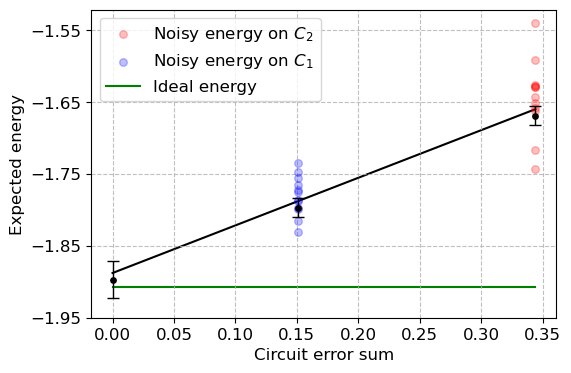

In [10]:
i = 4
j = 76
k = 43

ev_ideal = all_evals_ideal[i][j]
x = np.array(all_error_sums[i])
y = all_sampled_ev
y_true = all_evals_noisy[i][j]

m, b = np.polyfit(np.mean(np.array(x).reshape(2, -1), axis=1), np.mean(np.array(all_sampled_ev).reshape(2, -1), axis=1), 1)
m, b_true = np.polyfit(np.mean(np.array(x).reshape(2, -1), axis=1), np.mean(np.array(y_true).reshape(2, -1), axis=1), 1)

font = {'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(6, 4), facecolor='w', edgecolor='k')
plt.scatter(x[:12], y[:12], label='Noisy energy on $C_1$', color='b', s=30, zorder=2, alpha=0.25)
plt.scatter(x[12:], y[12:], label='Noisy energy on $C_2$', color='r', s=30, zorder=2, alpha=0.25)
sigmas = [np.sqrt(np.sum(np.array(all_sampled_std[:12])**2))/12, np.sqrt(np.sum(np.array(all_sampled_std[12:])**2))/12]
x1, x2 = x[0], x[-1]
plt.errorbar(x=[x1, x2], y=[np.mean(y_true[:12]), np.mean(y_true[12:])],
             yerr=sigmas,
             color='k', zorder=3, elinewidth=1, capsize=4, linestyle='None')
plt.errorbar(x=[0], y=b_true, yerr=np.sqrt((x2**2 * sigmas[0]**2+x1**2 * sigmas[1]**2)/(x2-x1)**2),
            color='k', zorder=3, elinewidth=1, capsize=4, linestyle='None')
plt.scatter(x=[0, x1, x2], y=[b_true, np.mean(y_true[:12]), np.mean(y_true[12:])],
            color='k', s=15, zorder=5)
x_regression = np.linspace(0, max(x), 100)  # 100 points
regression_line = m * x_regression + b

plt.plot(x_regression, regression_line, color='k', label='_nolegend_', zorder=1)
plt.plot(x_regression, ev_ideal*np.ones_like(x_regression), color='g', label='Ideal energy', zorder=0)
plt.ylabel("Expected energy")
plt.xlabel('Circuit error sum')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.8)
plt.yticks(np.linspace(-1.55, -1.95, 5))
handles, labels = plt.gca().get_legend_handles_labels()
handles[:2] = handles[1::-1]
labels[:2] = labels[1::-1]
plt.legend(handles, labels, loc='upper left')
plt.show()